In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P21NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 26123 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4465 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

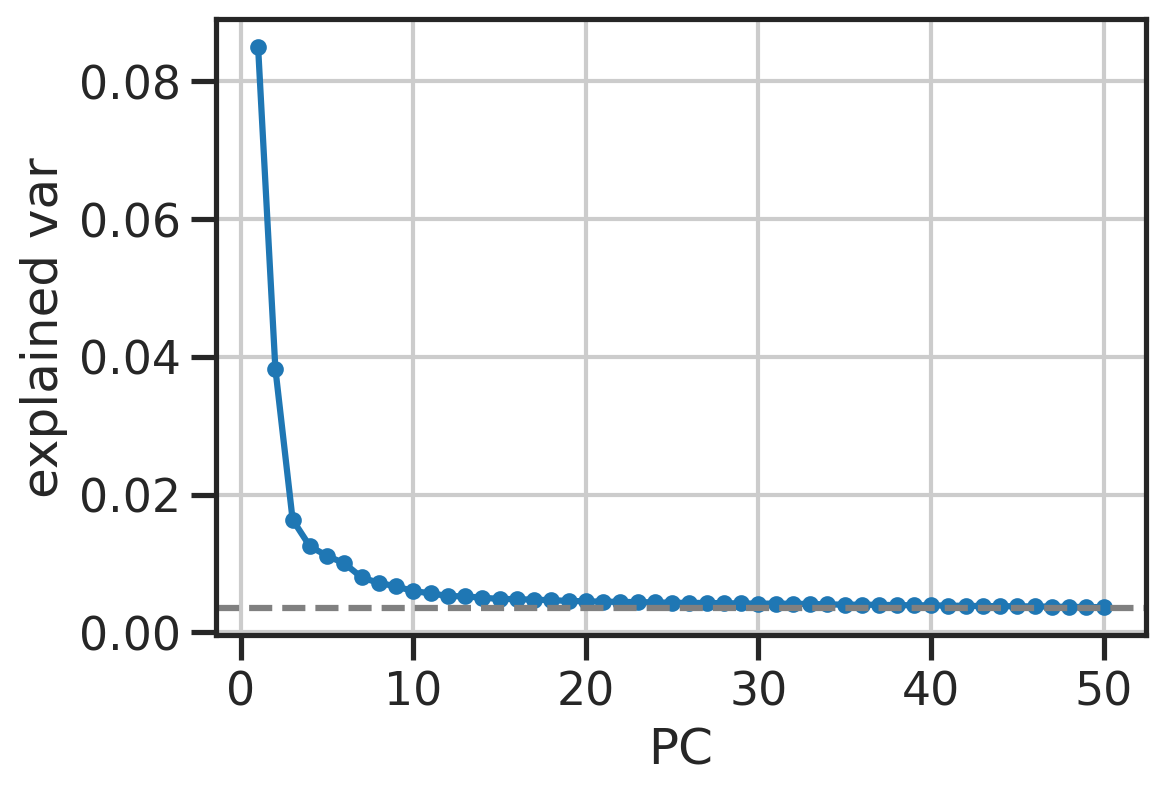

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

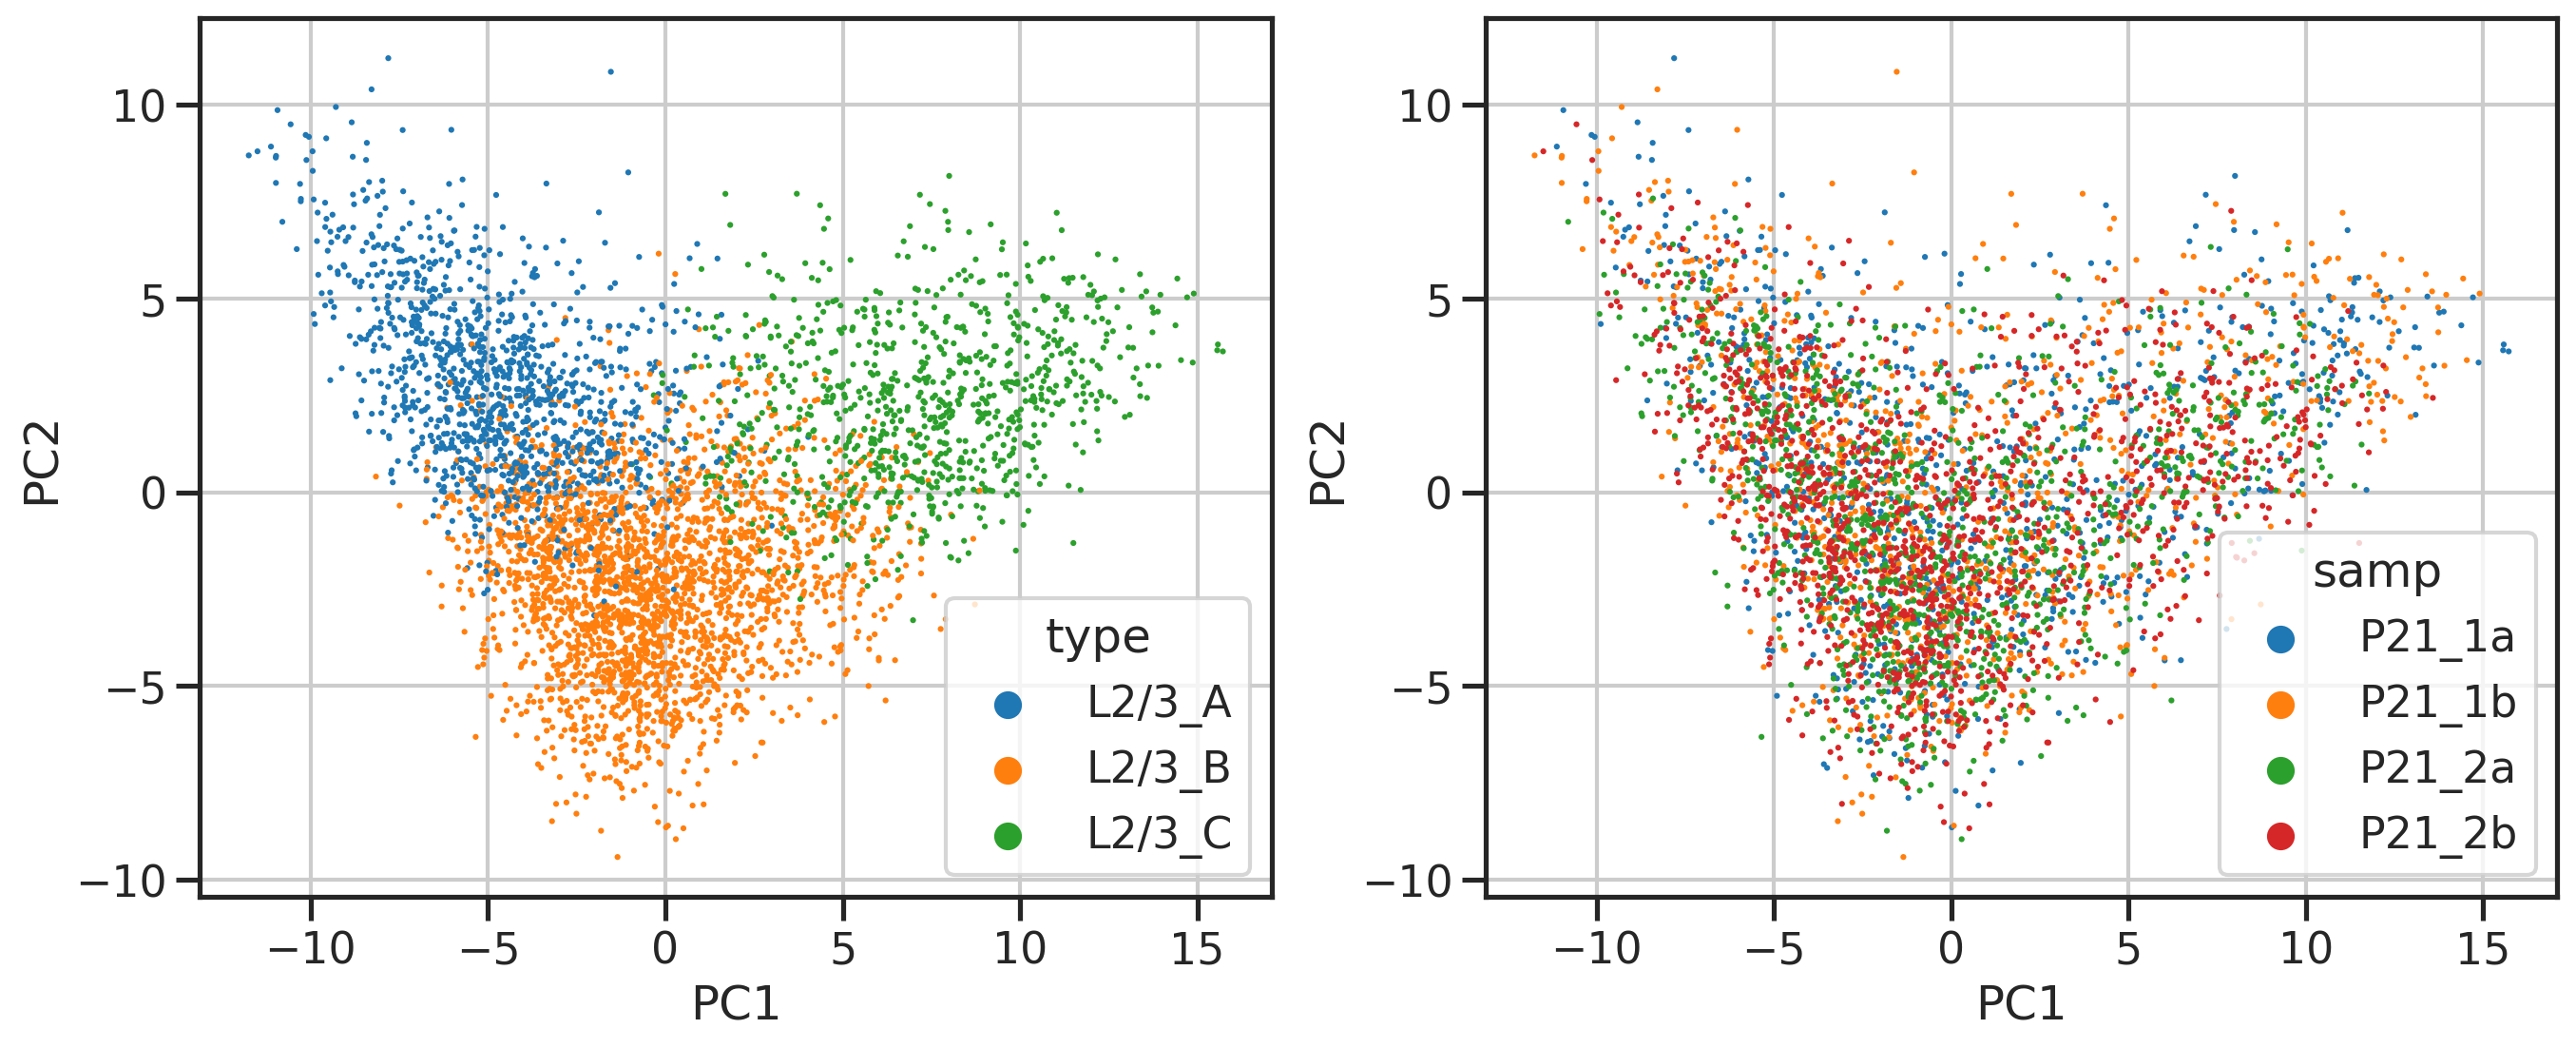

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

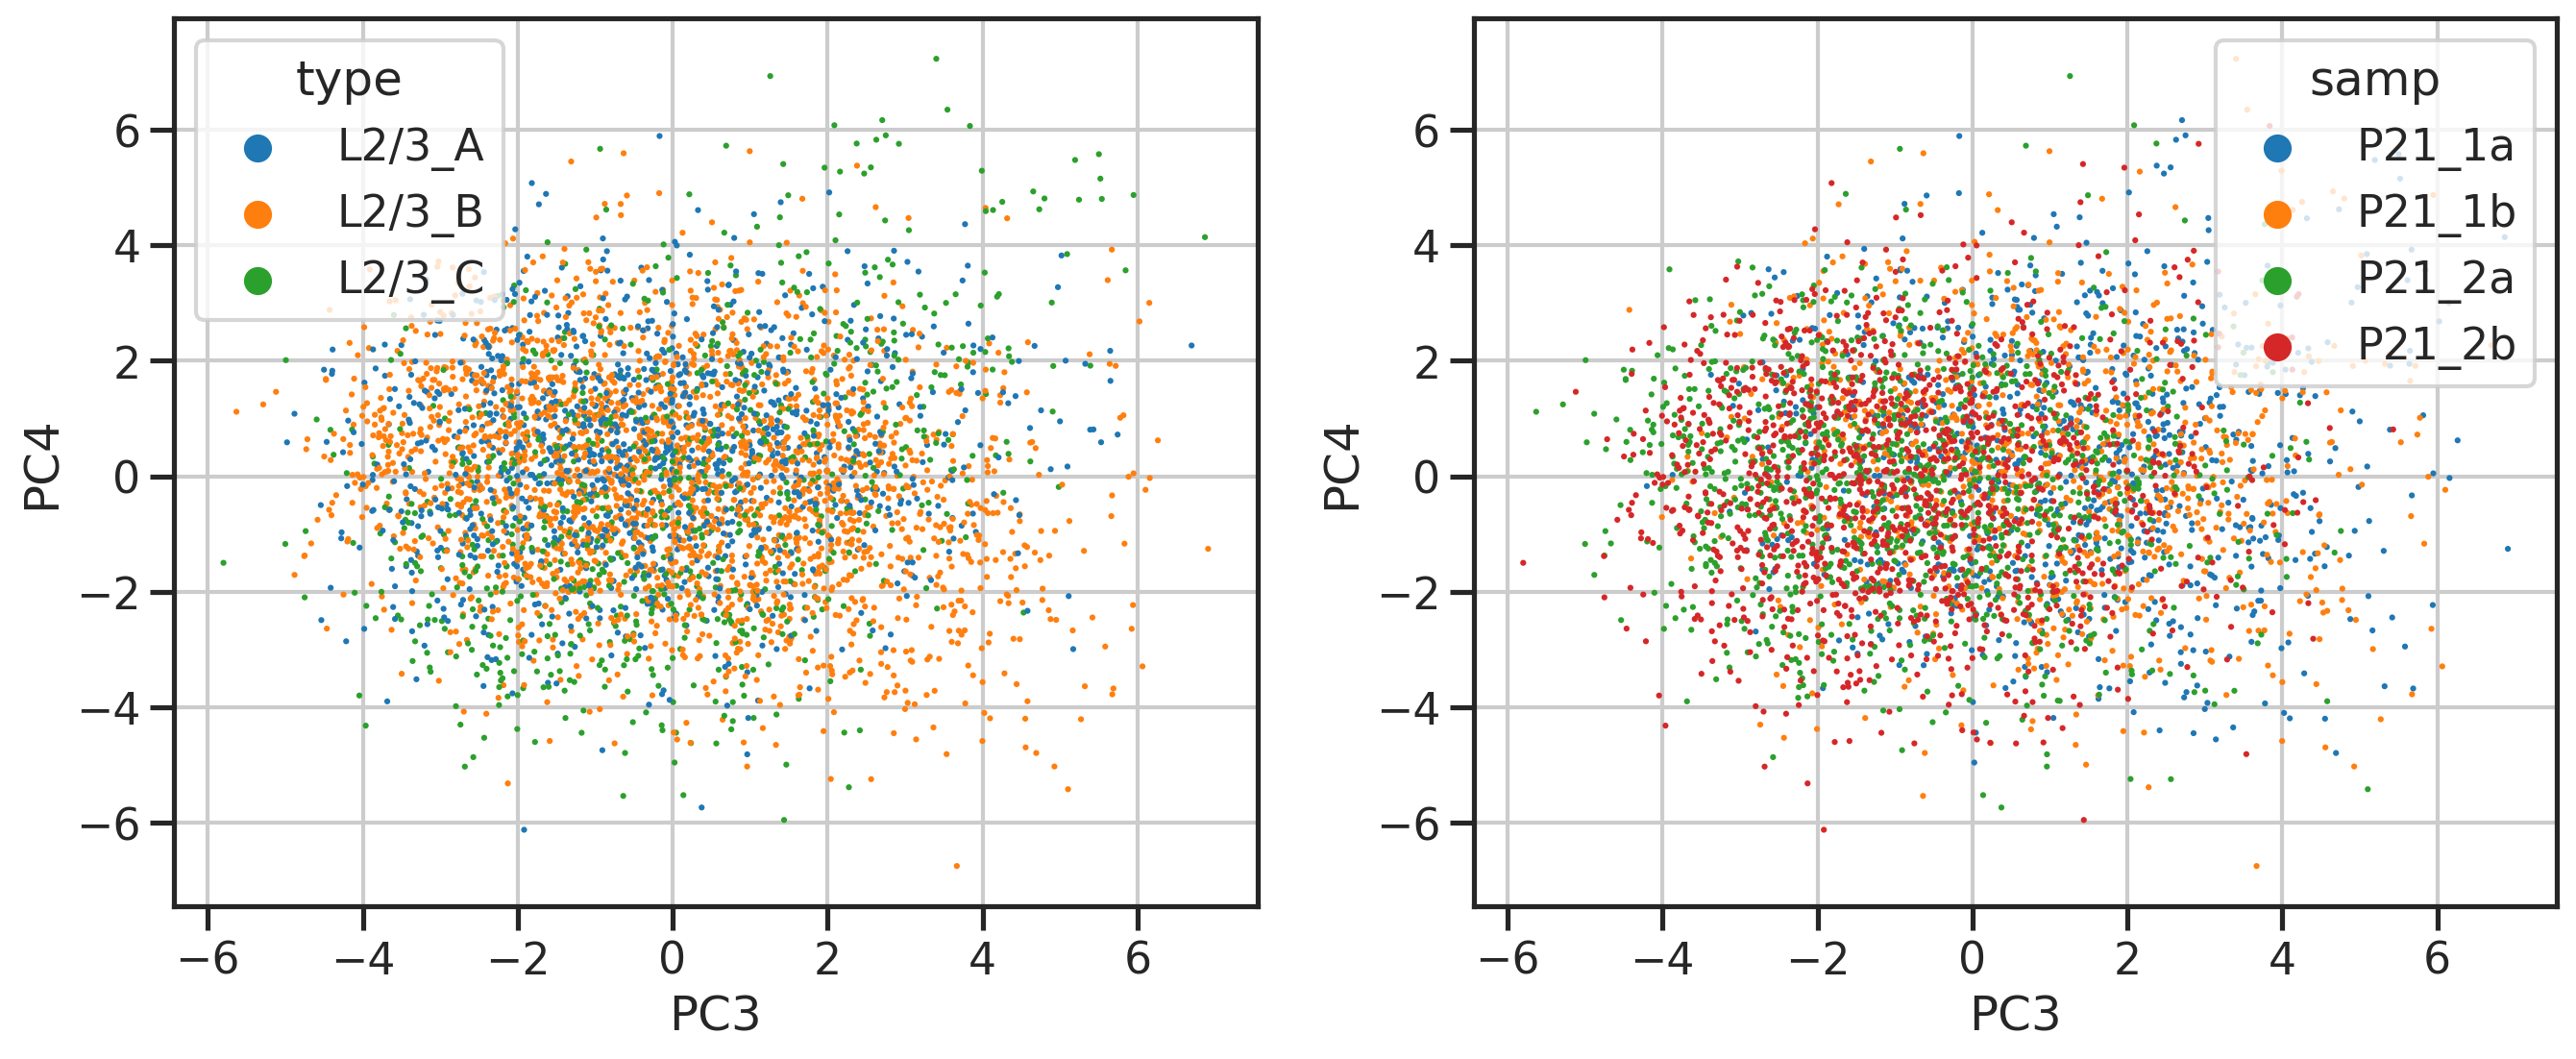

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

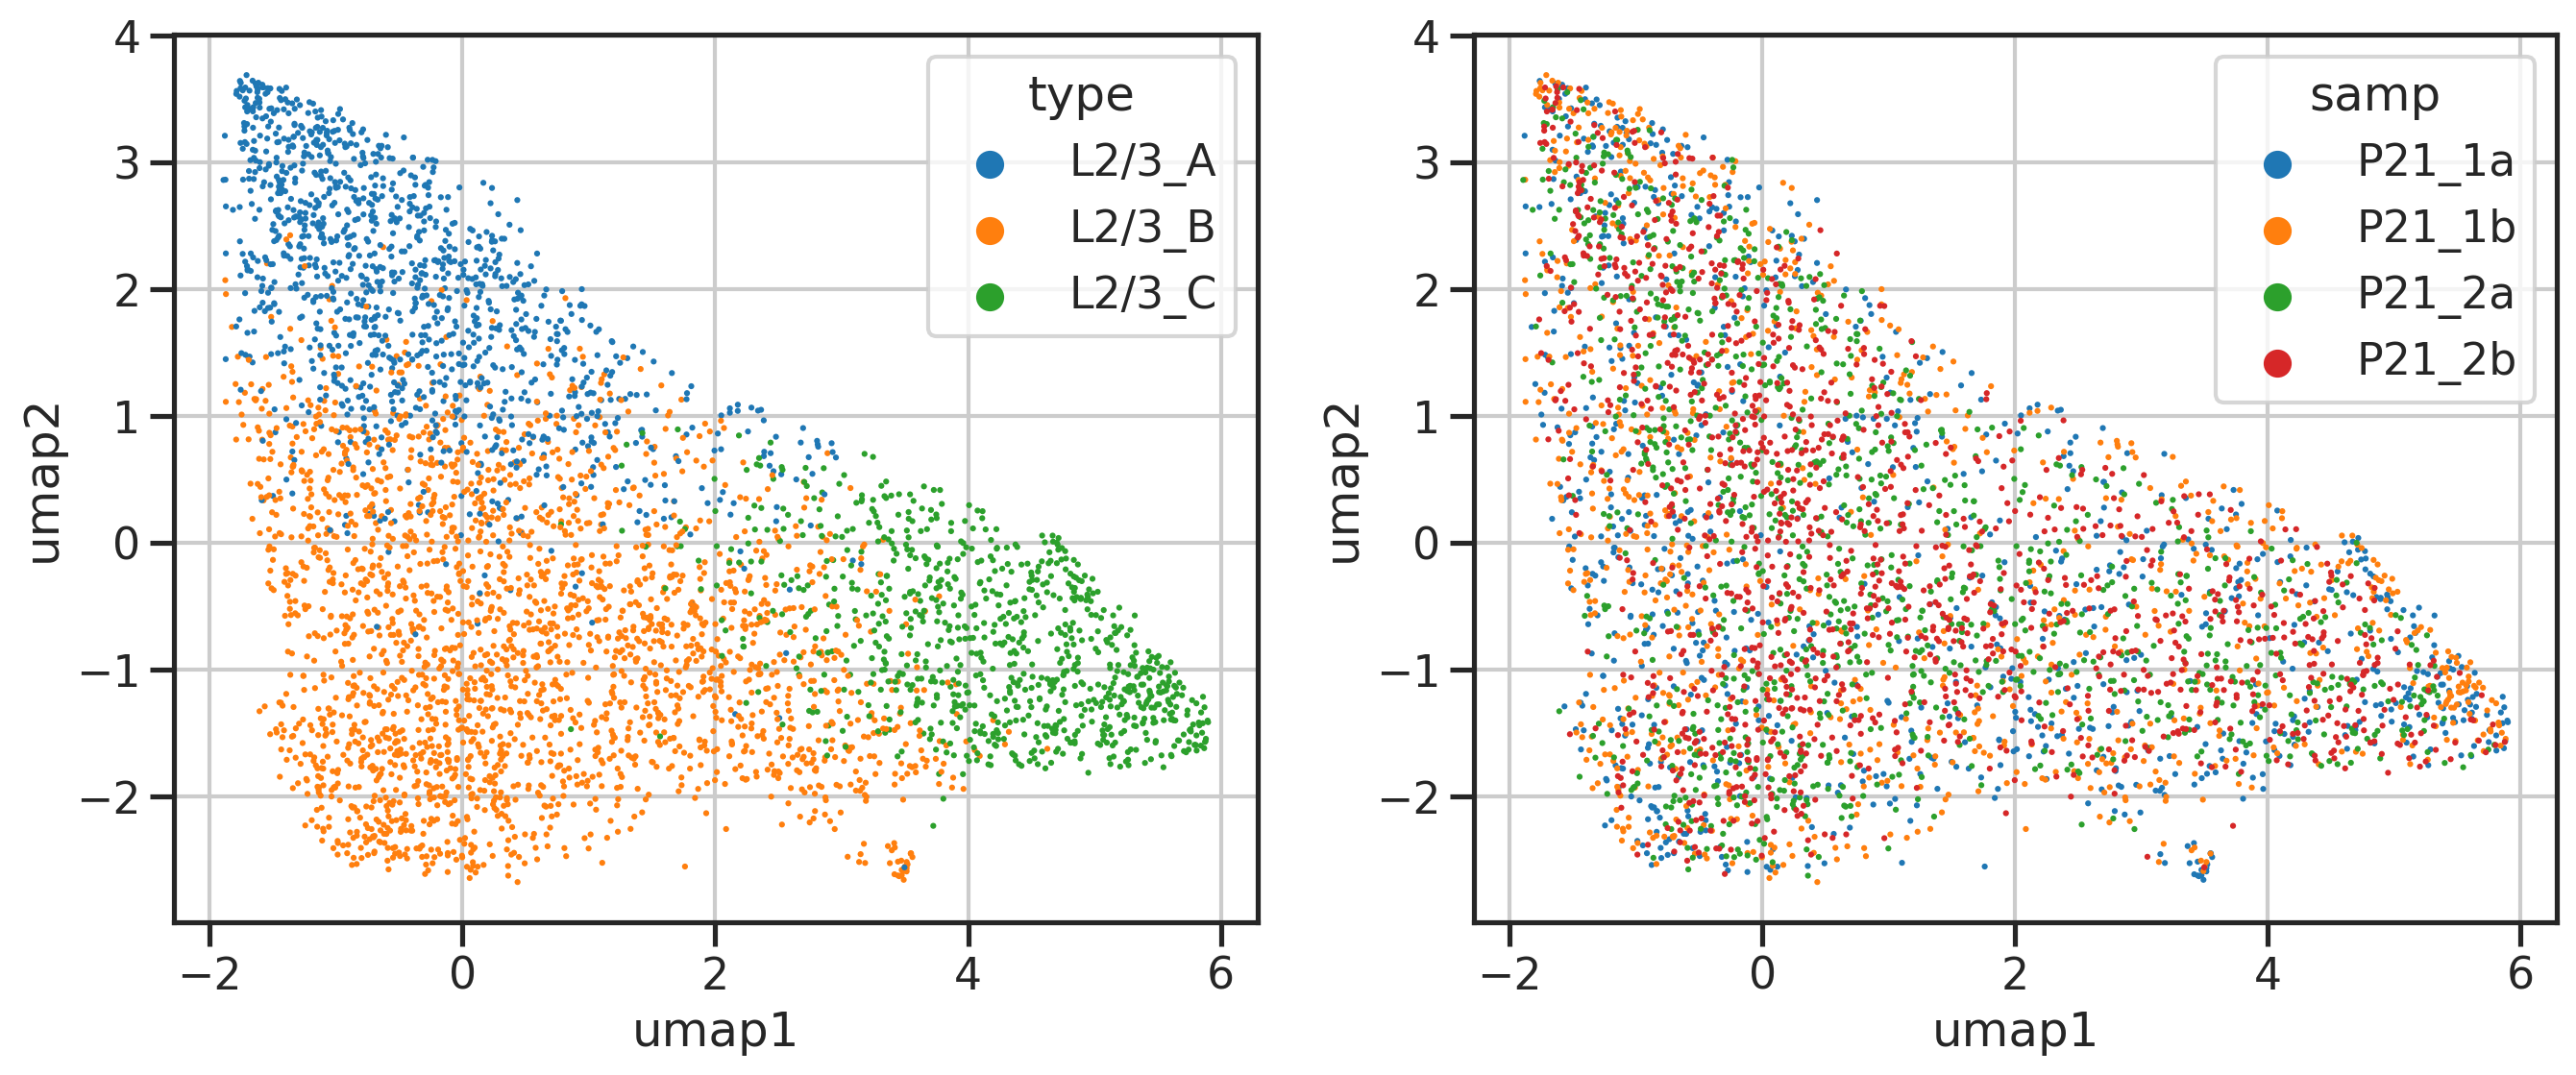

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

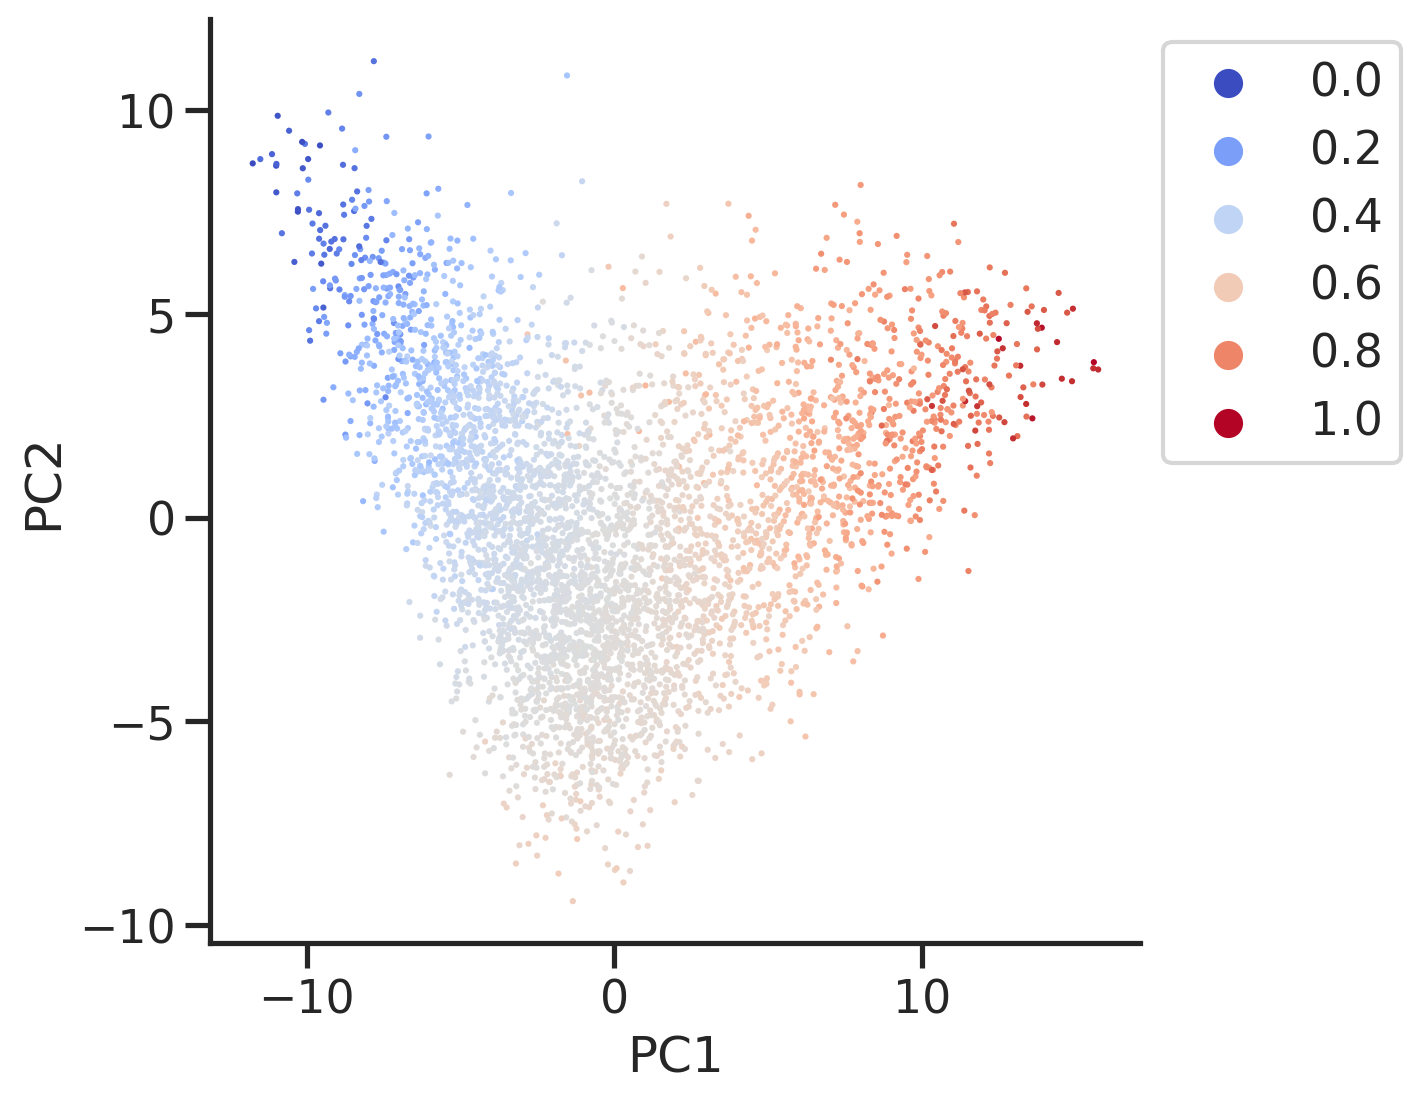

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:05:18 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


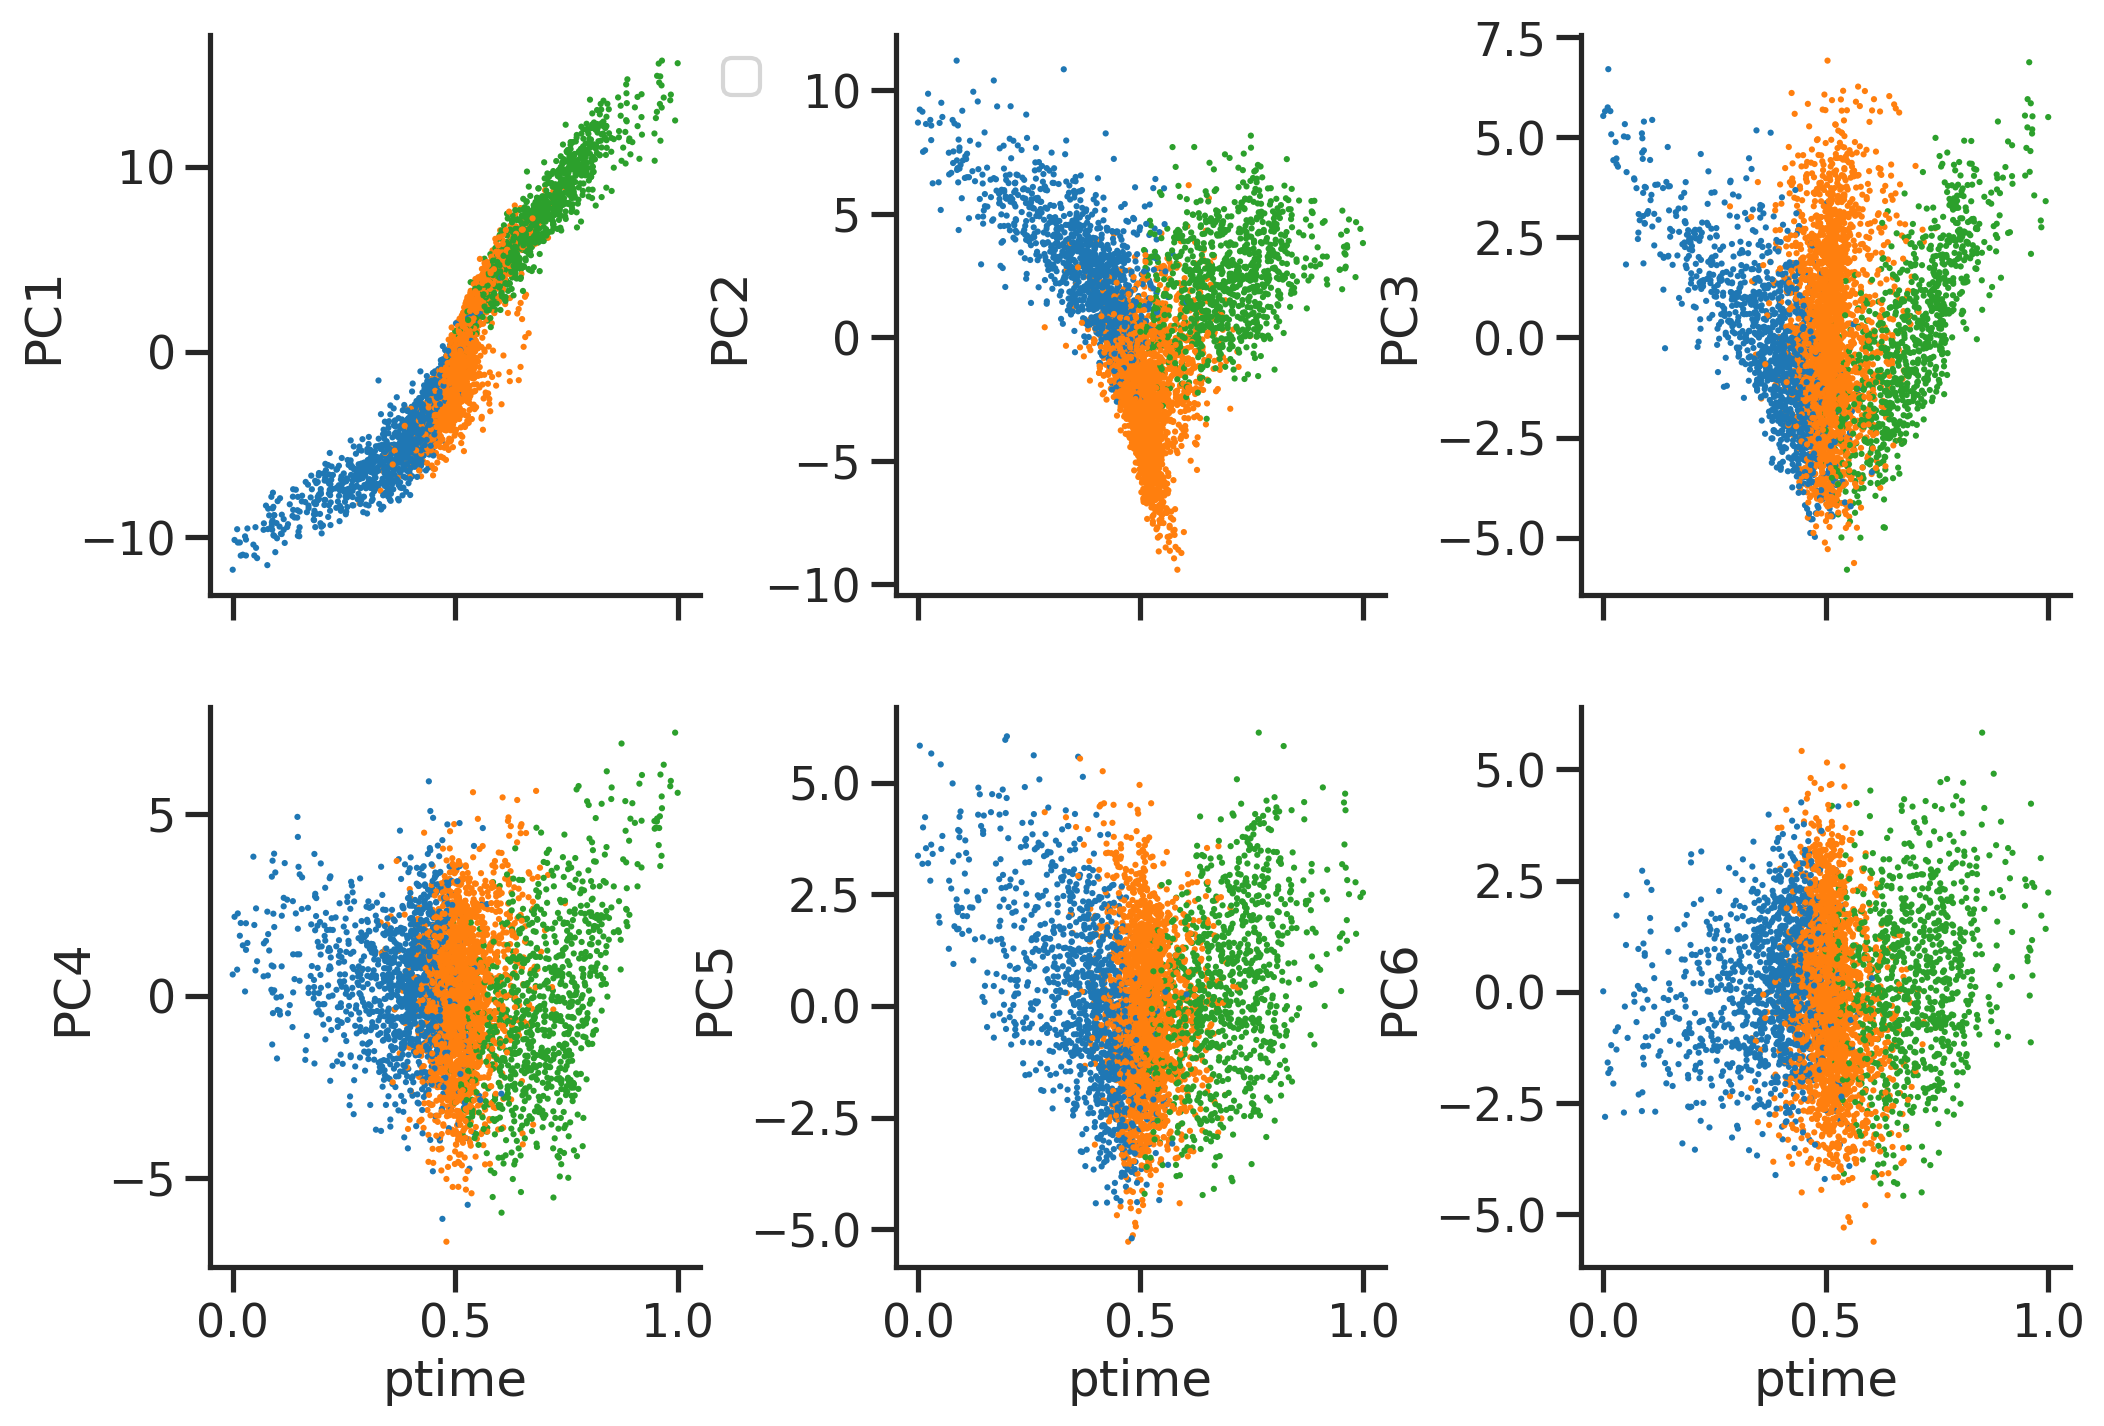

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:05:25 - maxp pruned
03-28 14:05:25 - cmap pruned
03-28 14:05:25 - kern dropped
03-28 14:05:25 - post pruned
03-28 14:05:25 - FFTM dropped
03-28 14:05:25 - GPOS pruned
03-28 14:05:25 - GSUB pruned
03-28 14:05:25 - name pruned
03-28 14:05:25 - glyf pruned
03-28 14:05:25 - Added gid0 to subset
03-28 14:05:25 - Added first four glyphs to subset
03-28 14:05:25 - Closing glyph list over 'GSUB': 34 glyphs before
03-28 14:05:25 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 'e', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:05:25 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 42, 49, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:05:25 - Closed glyph list over 'GSUB': 34 glyphs after
03-28 14:05:25 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', '

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P21NR_v4_2023-03-28.pdf


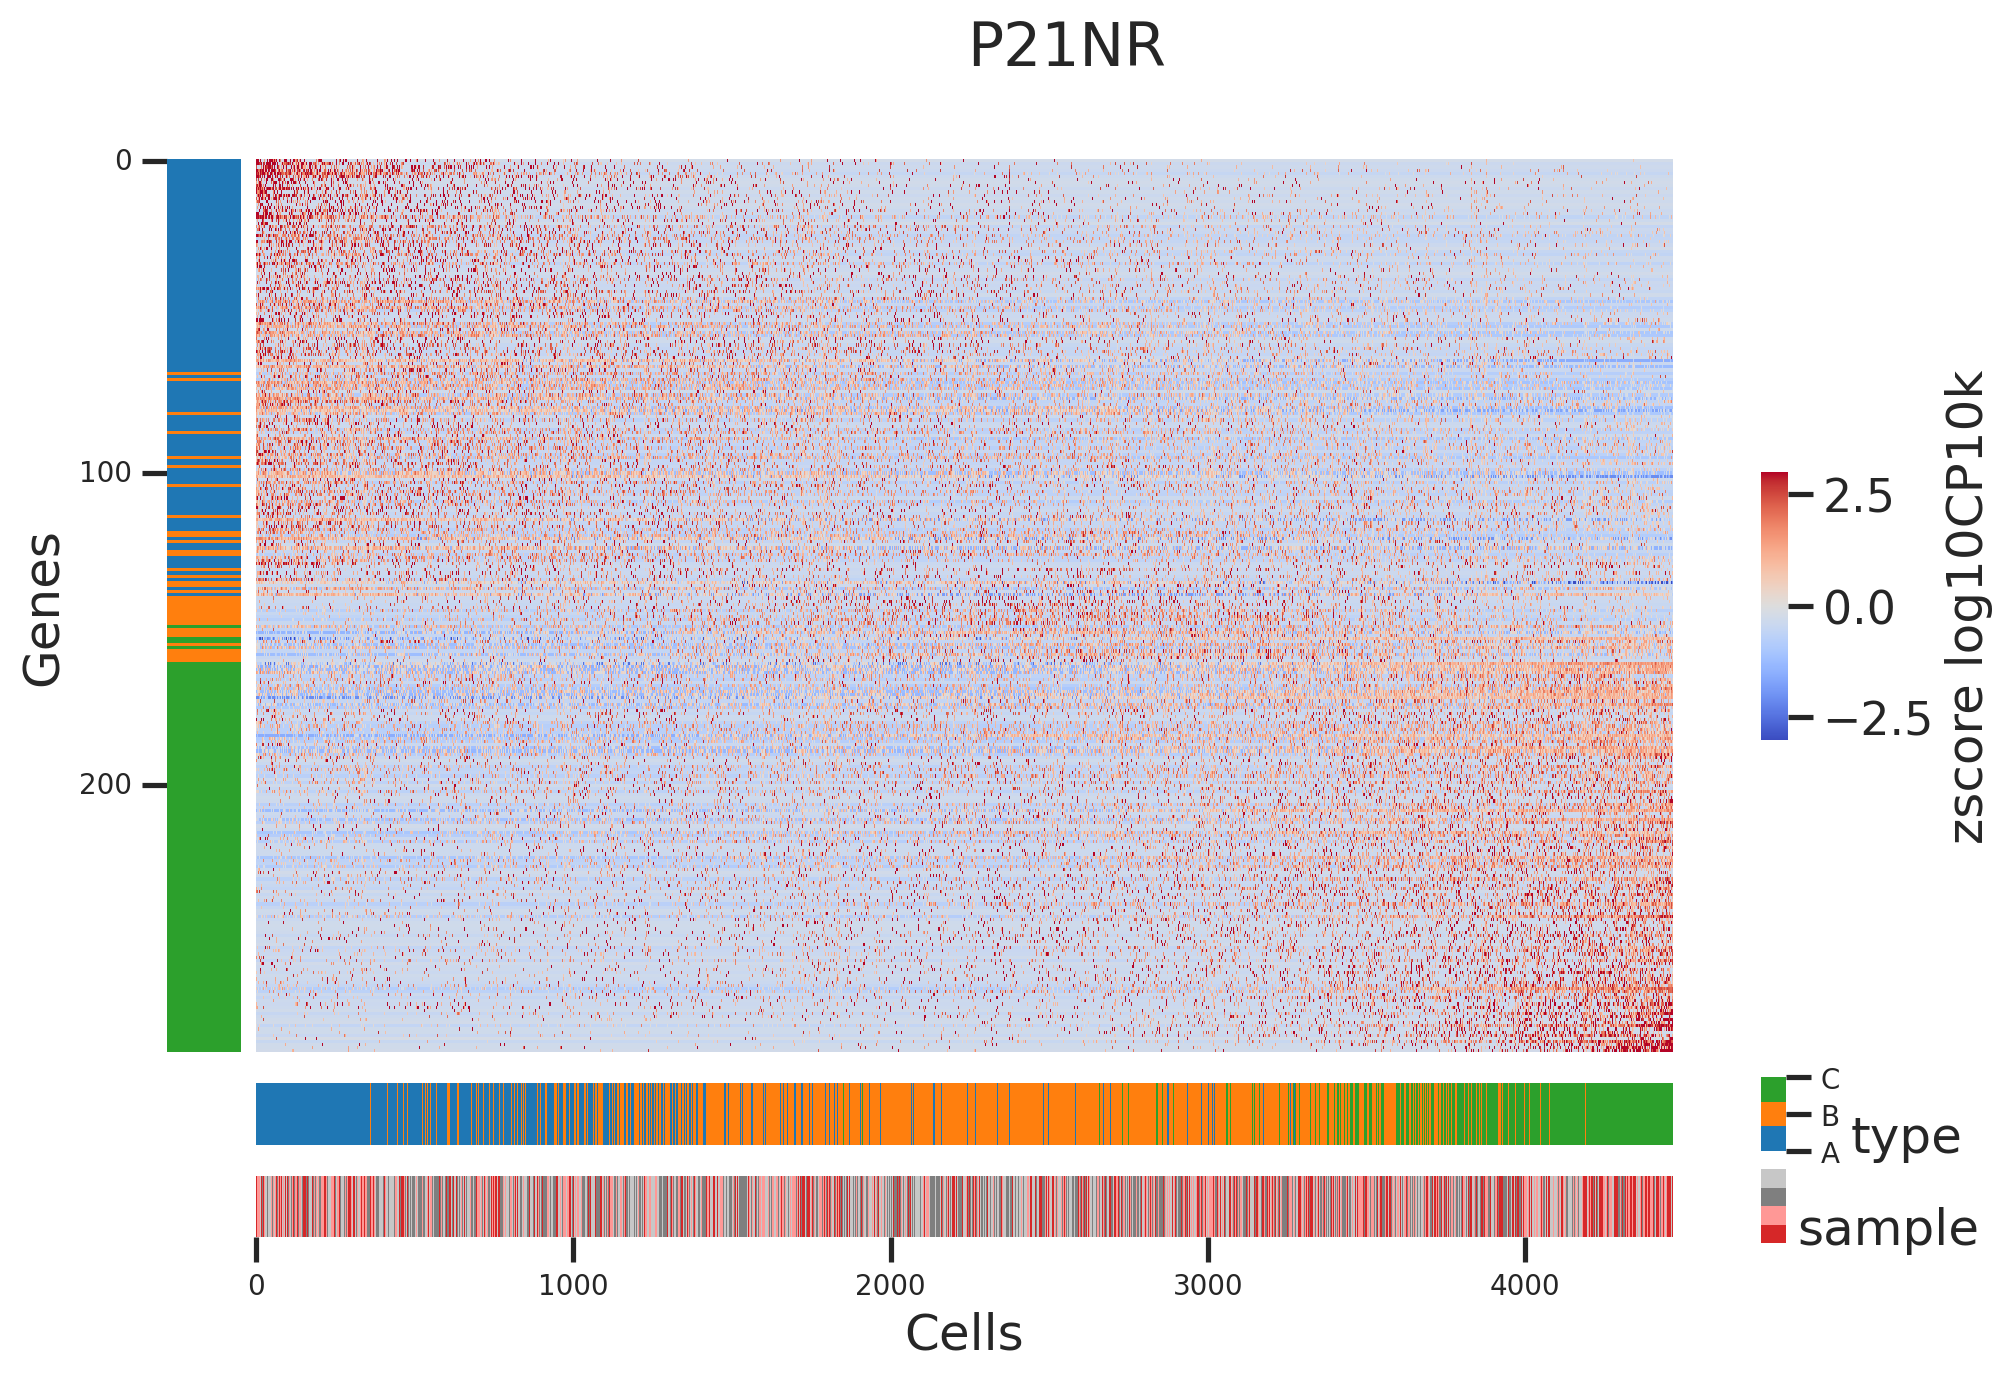

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACGCTTCTGCGAGC-1-P21_1a-P21   4.189253 -0.869014  2.642469  2.535846   
AAAGGGCCAGCTCGGT-1-P21_1a-P21  -4.137934  0.466099  0.059508  0.531738   
AAAGGGCTCCGTGGGT-1-P21_1a-P21   8.010129  3.139441  0.199258 -0.372430   
AAAGTCCGTGTGGACA-1-P21_1a-P21  12.081086  4.393816  2.973823  2.640470   
AAAGTCCTCTCCGAAA-1-P21_1a-P21   1.639624 -1.142344 -0.943912  2.612849   
...                                  ...       ...       ...       ...   
TTTGATCTCACGTAGT-1-P21_2b-P21  -0.561085 -1.667271 -2.092191 -2.205964   
TTTGGTTAGCAGTCTT-1-P21_2b-P21   3.540734  3.885048 -1.174723 -4.443031   
TTTGGTTGTGGCTTGC-1-P21_2b-P21  -6.493589 -0.195038 -1.301536  0.390484   
TTTGTTGAGGTATAGT-1-P21_2b-P21  -7.511477  3.173505  0.856396  0.998427   
TTTGTTGTCGCCAGTG-1-P21_2b-P21  -2.171956 -0.837061 -2.240141 -0.435322   

                                    PC5       PC6       PC7       PC8  \
AAACGCTTCTGCGAGC-1-P21_1a-P21 -2.356869 -1.163554 -0.417193 -0.830485   
AAAGGGCCAGCTCGGT-1-P21_1a-P21 -0.169178 -1.861467 -1.885832  1.584095   
AAAGGGCTCCGTGGGT-1-P21_1a-P21  0.020681 -1.245446  0.161150  3.525505   
AAAGTCCGTGTGGACA-1-P21_1a-P21  0.894753  0.728612 -0.419792  0.004351   
AAAGTCCTCTCCGAAA-1-P21_1a-P21 -2.897204  0.247741 -0.751541  1.132051   
...                                 ...       ...       ...       ...   
TTTGATCTCACGTAGT-1-P21_2b-P21  0.507292  0.087298  0.614124 -2.621420   
TTTGGTTAGCAGTCTT-1-P21_2b-P21 -1.574884  1.999270 -0.604449  1.027514   
TTTGGTTGTGGCTTGC-1-P21_2b-P21  1.972924  1.349197 -1.292550 -0.105819   
TTTGTTGAGGTATAGT-1-P21_2b-P21 -0.927881  1.885306  2.150270 -1.068352   
TTTGTTGTCGCCAGTG-1-P21_2b-P21  0.547510  0.622895 -1.627609  0.901430   

                                    PC9      PC10  ...      PC46      PC47  \
AAACGCTTCTGCGAGC-1-P21_1a-P21 -1.723503 -0.481229  ...  0.547417 -0.005877   
AAAGGGCCAGCTCGGT-1-P21_1a-P21 -0.438836 -1.630379  ...  1.031418  0.790888   
AAAGGGCTCCGTGGGT-1-P21_1a-P21 -0.648804  0.114067  ... -0.640549 -0.974443   
AAAGTCCGTGTGGACA-1-P21_1a-P21  0.844892  1.161196  ...  0.723697 -0.372724   
AAAGTCCTCTCCGAAA-1-P21_1a-P21 -0.027968  2.223883  ...  1.421942 -0.729686   
...                                 ...       ...  ...       ...       ...   
TTTGATCTCACGTAGT-1-P21_2b-P21  0.439249  0.651033  ...  0.995184  1.071856   
TTTGGTTAGCAGTCTT-1-P21_2b-P21 -0.099087  0.044065  ... -0.392458 -0.178955   
TTTGGTTGTGGCTTGC-1-P21_2b-P21 -0.938145 -1.219104  ...  0.298959  1.341618   
TTTGTTGAGGTATAGT-1-P21_2b-P21  0.109718  1.524755  ... -0.300283 -0.227882   
TTTGTTGTCGCCAGTG-1-P21_2b-P21 -0.739139  1.042129  ... -0.360861  0.183290   

                                   PC48      PC49      PC50    type    samp  \
AAACGCTTCTGCGAGC-1-P21_1a-P21 -1.251421  0.300481  0.080503  L2/3_B  P21_1a   
AAAGGGCCAGCTCGGT-1-P21_1a-P21 -0.085126  0.145532  1.576862  L2/3_B  P21_1a   
AAAGGGCTCCGTGGGT-1-P21_1a-P21  1.406631  0.010650  0.228615  L2/3_C  P21_1a   
AAAGTCCGTGTGGACA-1-P21_1a-P21  0.761715 -0.520924 -0.593769  L2/3_C  P21_1a   
AAAGTCCTCTCCGAAA-1-P21_1a-P21  1.265306  1.077816  1.647648  L2/3_B  P21_1a   
...                                 ...       ...       ...     ...     ...   
TTTGATCTCACGTAGT-1-P21_2b-P21 -1.247012 -0.478012 -1.101522  L2/3_B  P21_2b   
TTTGGTTAGCAGTCTT-1-P21_2b-P21 -1.765742 -0.366172  0.548513  L2/3_C  P21_2b   
TTTGGTTGTGGCTTGC-1-P21_2b-P21  0.210995  0.557961 -0.801241  L2/3_A  P21_2b   
TTTGTTGAGGTATAGT-1-P21_2b-P21  1.092804  1.783615  1.213731  L2/3_A  P21_2b   
TTTGTTGTCGCCAGTG-1-P21_2b-P21  0.534701 -0.941136 -0.375353  L2/3_B  P21_2b   

                                  umap1     umap2     ptime  
AAACGCTTCTGCGAGC-1-P21_1a-P21  3.365162 -2.391079  0.602294  
AAAGGGCCAGCTCGGT-1-P21_1a-P21 -0.507963  1.248676  0.430928  
AAAGGGCTCCGTGGGT-1-P21_1a-P21  4.742194 -0.913726  0.689553  
AAAGTCCGTGTGGACA-1-P21_1a-P21  5.383462 -1.415008  0.806809  
AAAGTCCTCTCCGAAA-1-P21_1a-P21  1.700211 -1.280820  0.522773  
...          

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)